In [1]:
import dLux as dl
import matplotlib.pyplot as plt
import jax.numpy as np

import webbpsf
import poppy
import pysiaf

from astropy.io import fits
from tqdm.notebook import tqdm

from jax.config import config
config.update("jax_enable_x64", True)

import warnings
warnings.filterwarnings("ignore")

dLux: Jax is running in 32-bit, to enable 64-bit visit:
https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


In [2]:
a2r = dl.utils.arcseconds_to_radians
r2a = dl.utils.radians_to_arcseconds

def d2r(x):
    return x*np.pi/180

def r2d(x):
    return x*180/np.pi

def rebin(array_in,factor):
    shape = array_in.shape
    reshaped = array_in.reshape(shape[0]//factor,factor, shape[1]//factor, factor)
    return reshaped.mean(-1).mean(1)

In [3]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

<Figure size 640x480 with 0 Axes>

In [4]:
from dLux.optics import OpticalLayer

class InvertY(OpticalLayer):
    def __init__(self):
        super().__init__("InvertY")

    def __call__(self, wavefront):
        return wavefront.invert_y()
    
class InvertX(OpticalLayer):
    def __init__(self):
        super().__init__("InvertX")

    def __call__(self, wavefront):
        return wavefront.invert_x()
    
class InvertXY(OpticalLayer):
    def __init__(self):
        super().__init__("InvertXY")

    def __call__(self, wavefront):
        return wavefront.invert_x_and_y()

In [5]:
# Make a matching webb osys
webb_osys = webbpsf.NIRISS()
webb_osys.filter = 'F430M'
webb_osys.pupil_mask = "MASK_NRM"
webb_osys.detector = 'NIS'

# Calc psf
webbpsf_fits, extras = webb_osys.calc_psf(return_intermediates=True)

In [6]:
head = webbpsf_fits[0].header
nwavels = head['NWAVES']
wavels, weights = [], []
for i in range(nwavels):
    wavels.append(head['WAVE'+str(i)])
    weights.append(head['WGHT'+str(i)])

spec = dl.ArraySpectrum(wavels, weights)
source = dl.PointSource(spectrum=spec)

In [7]:
# Get osys and planes
niriss = webb_osys.optsys
pupil_plane = niriss.planes[0]
det_plane = niriss.planes[-1]

# Wavefront 
npix = 1024
diameter = pupil_plane.pixelscale.to('m/pix').value * pupil_plane.npix

# Aperture and OPD
AMI = dl.utils.scale_array(niriss.planes[3].amplitude, npix, 1)
opd = dl.utils.scale_array(niriss.planes[0].opd, npix, 1)

# Fied depended aberration
FDA = niriss.planes[2].opd

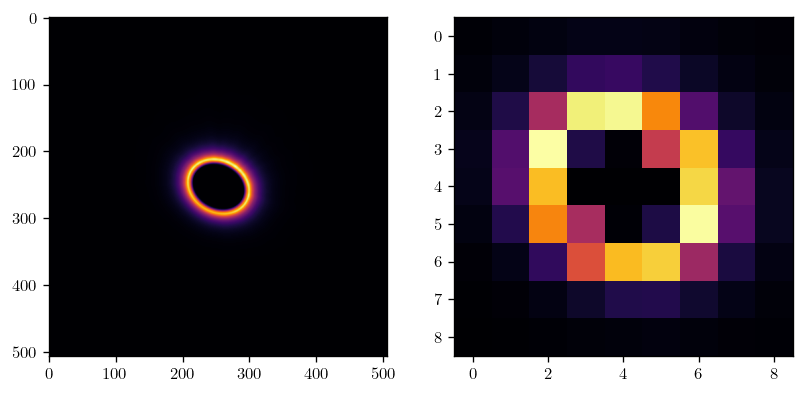

In [55]:
oversample = 11

sim = fits.getdata('../exozodi_v2/images/image_4um_eta_corvi_exozodi_axisym.fits').squeeze()
ijstar=np.unravel_index(sim.argmax(), sim.shape)
sim[ijstar]=0.0
sim = sim[3:-3,3:-3]

ring = rebin(sim,oversample)
ring = ring[14:-14,14:-14]
ring = rebin(ring,2)
ring /= ring.sum()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8.0,5.0))
ax1.imshow(sim)
ax2.imshow(ring)

# plt.colorbar()
plt.show()

In [56]:
det_npix = 60 * oversample

# Make layers
optical_layers = [
    dl.CreateWavefront(npix, diameter, 'Angular'),
    dl.AddOPD(opd),
    InvertY(),
    dl.AddOPD(FDA),
    dl.TransmissiveOptic(AMI),
    dl.AngularMFT(det_npix, a2r(nis_pscale_asec/oversample)),
    InvertXY(),
]

# Make components
optics = dl.Optics(optical_layers)
detector = dl.Detector([dl.IntegerDownsample(oversample)])

In [57]:
# Make sources
p = a2r(nis_pscale_asec/oversample)
position = [p/2, -p/2]
position = [0, 0]

contrast = 1e2

source = dl.PointExtendedSource(position, spectrum=spec, contrast=contrast, distribution=ring, flux=0.5*1e10, name='source')
point_source = dl.PointSource(position, spectrum=spec, flux=1e10, name='source')

# Make telescope
tel = dl.Instrument(optics=optics, detector=detector, sources=[source])

# Make psfs
psf = tel.model()
point_psf = tel.set('source', point_source).model()

# Normalise psfs properly
psf /= psf.sum()
point_psf /= point_psf.sum()

psf *= 0.95 * 1e8
point_psf *= 0.95 * 1e8

# Add photon noise
import jax.random as jr
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
point_psf_photon = jr.poisson(jr.PRNGKey(1), point_psf)

95000000.0 95000000.00000001


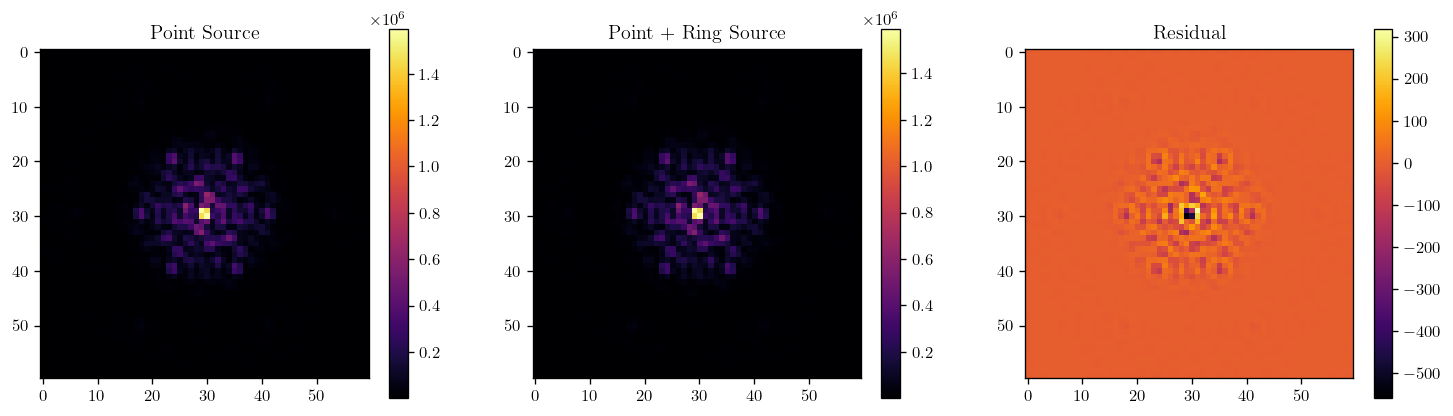

In [58]:
print(psf.sum(), point_psf.sum())

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Point Source")
plt.imshow(point_psf_photon)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Point + Ring Source")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(psf - point_psf)
plt.colorbar()
plt.show()

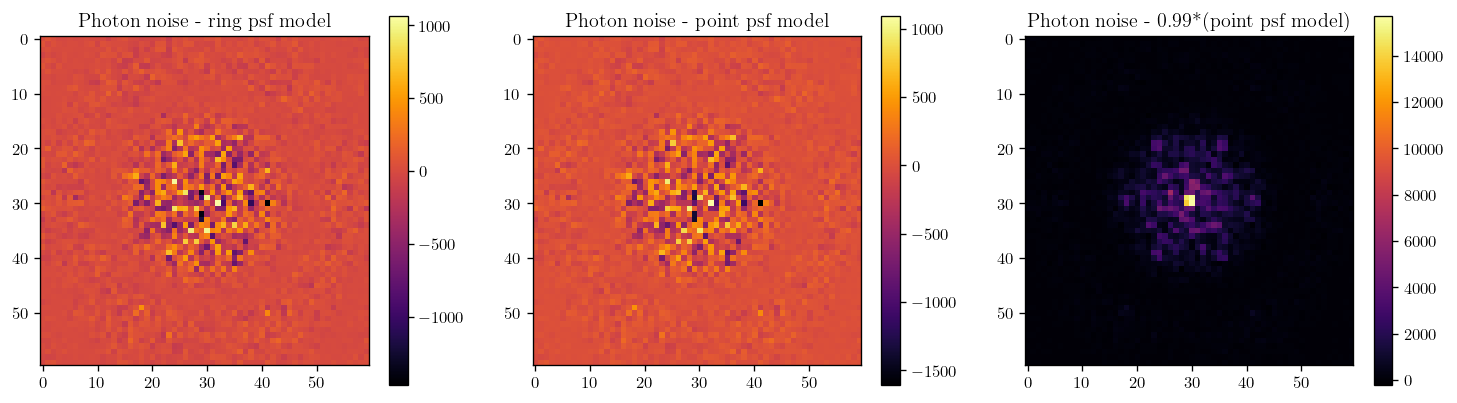

In [59]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Photon noise - ring psf model")
plt.imshow(psf_photon - psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Photon noise - point psf model")
plt.imshow(psf_photon - point_psf)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Photon noise - 0.99*(point psf model)")
plt.imshow(psf_photon - 0.99*point_psf)
plt.colorbar()
plt.show()

In [60]:
chi2_ring = np.square(psf_photon - psf).sum()
chi2_point = np.square(psf_photon - point_psf).sum()

print(chi2_ring)
print(chi2_point)
print(chi2_point/chi2_ring)

86651125.17252207
90706247.60515016
1.0467982663185778


## Now let's figure out what the visibilities look like!

In [61]:
from sibylla_lite import * 

from nrm_analysis.misctools import mask_definitions


In [62]:
f2f,mask = mask_definitions.jwst_g7s6c()
barray, bls = makebaselines(mask)

thisu = onp.subtract.outer(mask[:,0],mask[:,0])
thisu = thisu.T[np.where(~np.eye(thisu.shape[0],dtype=bool))]

thisv = onp.subtract.outer(mask[:,1],mask[:,1])
thisv = thisv.T[np.where(~np.eye(thisv.shape[0],dtype=bool))]

bls = np.array([thisv,thisu]).T
# bls = np.array([bls[:,1],bls[:,0]]).T # some weird orientation problem

In [63]:
x = 66*(np.arange(point_psf.shape[0])-point_psf.shape[0]/2)
xx, yy = np.meshgrid(x,x)
ami_transform = UVNonUniform(bls, xx, yy, 4.3e-6)

us = np.linspace(-6,6,100)
uniform_transform = UVGrid(us, -us, 66, 4.3e-6, psf_photon.shape[0])

In [64]:
%%time
uniform = uniform_transform(psf_photon) # neither of these is jitted
otf_uniform = uniform_transform(point_psf) # neither of these is jitted
# uniform /= otf_uniform

sparse = ami_transform(psf_photon)
otf_ami = ami_transform(point_psf)
sparse /= otf_ami

CPU times: user 1.64 ms, sys: 1.89 ms, total: 3.53 ms
Wall time: 2.1 ms


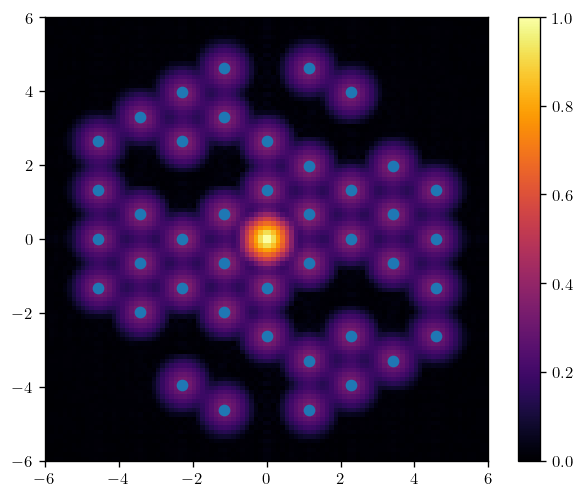

In [65]:
plt.imshow(np.abs(uniform)**0.5,extent=[us.min(),us.max(),us.min(),us.max()])
plt.scatter(bls[:,0],bls[:,1])
plt.colorbar()

In [66]:
from vis_tools import vis_ring_high_contrast
wavel = 4.3e-6
upred, vpred = np.linspace(0,bls[:,0].max()), np.linspace(0,bls[:,1].max())
wpred = np.sqrt(upred**2 + vpred**2)

Text(0.5, 0, 'Baseline (m)')

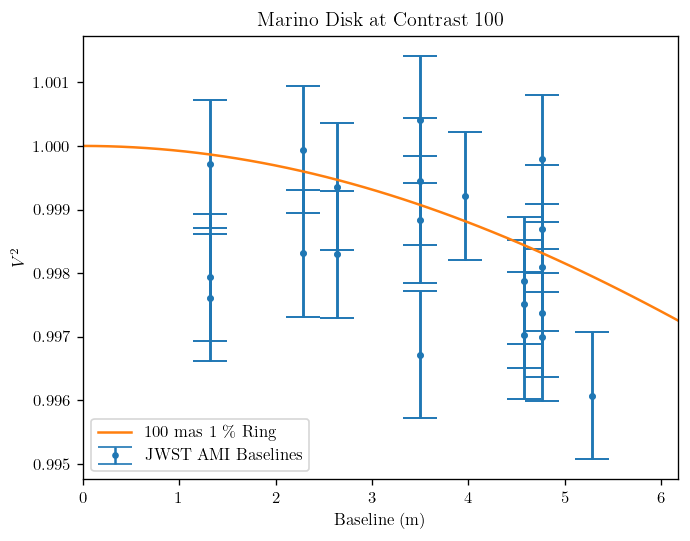

In [68]:
v2 = np.abs(sparse)**2
w = np.sqrt((bls**2).sum(axis=1))
v2pred = vis_ring_high_contrast(50.,contrast,upred/wavel,vpred/wavel)
# plt.plot(w, v2,'.')

plt.errorbar(w,v2,
             yerr=0.001,linestyle='none',fmt='.',capsize=10,label='JWST AMI Baselines')
plt.plot(wpred, v2pred,'-',label='100 mas 1 \% Ring')

plt.xlim(0,wpred.max()*0.95)
plt.legend()

plt.title('Marino Disk at Contrast %.d' % contrast)
plt.ylabel(r'$V^2$')
plt.xlabel('Baseline (m)')